# Declaring the Model

In [ ]:
! pip install onnx
! pip install onnxruntime
! pip install optimum

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)   # Assuming input image channel=3 (RGB), 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # Assuming 10 classes for output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)  # Reshape before passing to fc layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
model = SimpleCNN()


# Saving the state_dict

In [ ]:
# Save model state_dict
torch.save(model.state_dict(), "simple_cnn_state_dict.pt")


# Loading the Model
1. You must "Create a new model object" before loading the state_dict

In [ ]:
# Create a new model object
model2 = SimpleCNN()

# Load the state_dict into the model
model2.load_state_dict(torch.load("simple_cnn_state_dict.pt"))


<All keys matched successfully>

# Printing the State Dict

In [ ]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model2.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.weight 	 torch.Size([6, 3, 5, 5])
conv1.bias 	 torch.Size([6])
conv2.weight 	 torch.Size([16, 6, 5, 5])
conv2.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])


# Exporting Model on ONNX Format

In [ ]:
import torch
import torchvision

dummy_input = torch.randn(1, 3, 224, 224)
model = torchvision.models.alexnet(pretrained=True)
torch.onnx.export(model, dummy_input, "model.onnx")


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('model.onnx')

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: np.random.randn(1,3,224,224).astype(np.float32)}
ort_outs = ort_session.run(None, ort_inputs)



# Exporting Transformers Model to ONNX format

In [ ]:
from optimum.onnxruntime import ORTModelForCausalLM
from transformers import AutoTokenizer

model_checkpoint = "gpt2"
save_directory = "onnx/"

# Load a model from transformers and export it to ONNX
ort_model = ORTModelForCausalLM.from_pretrained(model_checkpoint, export=True)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Save the onnx model and tokenizer
ort_model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Framework not specified. Using pt to export to ONNX.


use_past = False is different than use_present_in_outputs = True, the value of use_present_in_outputs value will be used for the outputs.


Using framework PyTorch: 2.0.1+cu118
Overriding 2 configuration item(s)
	- use_cache -> True
	- pad_token_id -> 0
/usr/local/lib/python3.10/dist-packages/transformers/models/gpt2/modeling_gpt2.py:807: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if batch_size <= 0:


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Using framework PyTorch: 2.0.1+cu118
Overriding 2 configuration item(s)
	- use_cache -> True
	- pad_token_id -> 0
Asked a sequence length of 16, but a sequence length of 1 will be used with use_past == True for `input_ids`.


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



Asked a sequence length of 16, but a sequence length of 1 will be used with use_past == True for `input_ids`.


('onnx/tokenizer_config.json',
 'onnx/special_tokens_map.json',
 'onnx/vocab.json',
 'onnx/merges.txt',
 'onnx/added_tokens.json',
 'onnx/tokenizer.json')

# Using for Inference

In [ ]:
from transformers import AutoTokenizer, pipeline
from optimum.onnxruntime import ORTModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("/content/onnx")
model = ORTModelForCausalLM.from_pretrained("/content/onnx")
onnx_gen = pipeline("text-generation", model=model, tokenizer=tokenizer)

text = "I Live in New York City. New York City is "
gen = onnx_gen(text)
print(gen)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': "I Live in New York City. New York City is ˜new' because I live in New York, where I live now, I take an apartment in the Bronx, and I'm going to travel all over the world just for this reason."}]


In [ ]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
id2label={0: 'background', 1: 'candy', 2: 'egg tart', 3: 'french fries', 4: 'chocolate', 5: 'biscuit', 6: 'popcorn', 7: 'pudding', 8: 'ice cream', 9: 'cheese butter', 10: 'cake', 11: 'wine', 12: 'milkshake', 13: 'coffee', 14: 'juice', 15: 'milk', 16: 'tea', 17: 'almond', 18: 'red beans', 19: 'cashew', 20: 'dried cranberries', 21: 'soy', 22: 'walnut', 23: 'peanut', 24: 'egg', 25: 'apple', 26: 'date', 27: 'apricot', 28: 'avocado', 29: 'banana', 30: 'strawberry', 31: 'cherry', 32: 'blueberry', 33: 'raspberry', 34: 'mango', 35: 'olives', 36: 'peach', 37: 'lemon', 38: 'pear', 39: 'fig', 40: 'pineapple', 41: 'grape', 42: 'kiwi', 43: 'melon', 44: 'orange', 45: 'watermelon', 46: 'steak', 47: 'pork', 48: 'chicken duck', 49: 'sausage', 50: 'fried meat', 51: 'lamb', 52: 'sauce', 53: 'crab', 54: 'fish', 55: 'shellfish', 56: 'shrimp', 57: 'soup', 58: 'bread', 59: 'corn', 60: 'hamburg', 61: 'pizza', 62: ' hanamaki baozi', 63: 'wonton dumplings', 64: 'pasta', 65: 'noodles', 66: 'rice', 67: 'pie', 68: 'tofu', 69: 'eggplant', 70: 'potato', 71: 'garlic', 72: 'cauliflower', 73: 'tomato', 74: 'kelp', 75: 'seaweed', 76: 'spring onion', 77: 'rape', 78: 'ginger', 79: 'okra', 80: 'lettuce', 81: 'pumpkin', 82: 'cucumber', 83: 'white radish', 84: 'carrot', 85: 'asparagus', 86: 'bamboo shoots', 87: 'broccoli', 88: 'celery stick', 89: 'cilantro mint', 90: 'snow peas', 91: ' cabbage', 92: 'bean sprouts', 93: 'onion', 94: 'pepper', 95: 'green beans', 96: 'French beans', 97: 'king oyster mushroom', 98: 'shiitake', 99: 'enoki mushroom', 100: 'oyster mushroom', 101: 'white button mushroom', 102: 'salad', 103: 'other ingredients'}
label2id={'background': 0, 'candy': 1, 'egg tart': 2, 'french fries': 3, 'chocolate': 4, 'biscuit': 5, 'popcorn': 6, 'pudding': 7, 'ice cream': 8, 'cheese butter': 9, 'cake': 10, 'wine': 11, 'milkshake': 12, 'coffee': 13, 'juice': 14, 'milk': 15, 'tea': 16, 'almond': 17, 'red beans': 18, 'cashew': 19, 'dried cranberries': 20, 'soy': 21, 'walnut': 22, 'peanut': 23, 'egg': 24, 'apple': 25, 'date': 26, 'apricot': 27, 'avocado': 28, 'banana': 29, 'strawberry': 30, 'cherry': 31, 'blueberry': 32, 'raspberry': 33, 'mango': 34, 'olives': 35, 'peach': 36, 'lemon': 37, 'pear': 38, 'fig': 39, 'pineapple': 40, 'grape': 41, 'kiwi': 42, 'melon': 43, 'orange': 44, 'watermelon': 45, 'steak': 46, 'pork': 47, 'chicken duck': 48, 'sausage': 49, 'fried meat': 50, 'lamb': 51, 'sauce': 52, 'crab': 53, 'fish': 54, 'shellfish': 55, 'shrimp': 56, 'soup': 57, 'bread': 58, 'corn': 59, 'hamburg': 60, 'pizza': 61, ' hanamaki baozi': 62, 'wonton dumplings': 63, 'pasta': 64, 'noodles': 65, 'rice': 66, 'pie': 67, 'tofu': 68, 'eggplant': 69, 'potato': 70, 'garlic': 71, 'cauliflower': 72, 'tomato': 73, 'kelp': 74, 'seaweed': 75, 'spring onion': 76, 'rape': 77, 'ginger': 78, 'okra': 79, 'lettuce': 80, 'pumpkin': 81, 'cucumber': 82, 'white radish': 83, 'carrot': 84, 'asparagus': 85, 'bamboo shoots': 86, 'broccoli': 87, 'celery stick': 88, 'cilantro mint': 89, 'snow peas': 90, ' cabbage': 91, 'bean sprouts': 92, 'onion': 93, 'pepper': 94, 'green beans': 95, 'French beans': 96, 'king oyster mushroom': 97, 'shiitake': 98, 'enoki mushroom': 99, 'oyster mushroom': 100, 'white button mushroom': 101, 'salad': 102, 'other ingredients': 103}
feature_extractor = SegformerFeatureExtractor()
model = SegformerForSemanticSegmentation.from_pretrained(
    "prem-timsina/segformer-b0-finetuned-food",
    id2label=id2label,
    label2id=label2id
)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [ ]:

import torch
import numpy as np
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from transformers import SegformerFeatureExtractor
from matplotlib import pyplot as plt
from PIL import Image
import requests
from io import BytesIO




# Load the feature extractor
url = 'https://raw.githubusercontent.com/bpbpublications/Building-Transformer-Models-with-PyTorch/main/chapter8/food_image.jpg'
response = requests.get(url)
image = Image.open(BytesIO(response.content)).convert("RGB")

inputs = feature_extractor(images=[image], return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(dim=1).squeeze().cpu().numpy()
grayscale_map = np.zeros((predictions.shape[0], predictions.shape[1]), dtype=np.uint8)
for label_id in id2label.keys():
    grayscale_map[predictions == label_id] = label_id

# Convert the grayscale map to a PIL image
segmentation_image = Image.fromarray(grayscale_map, mode='L')


In [ ]:
# Create a dictionary for the counts of each class in the image
unique, counts = np.unique(predictions, return_counts=True)
class_counts = dict(zip(unique, counts))

# Map the class IDs back to their names
class_counts = {id2label[k]: v for k, v in class_counts.items()}

print(class_counts)


{'background': 3929, 'chicken duck': 3950, 'corn': 2, 'rice': 6153, 'asparagus': 314, 'cilantro mint': 156, 'French beans': 1880}


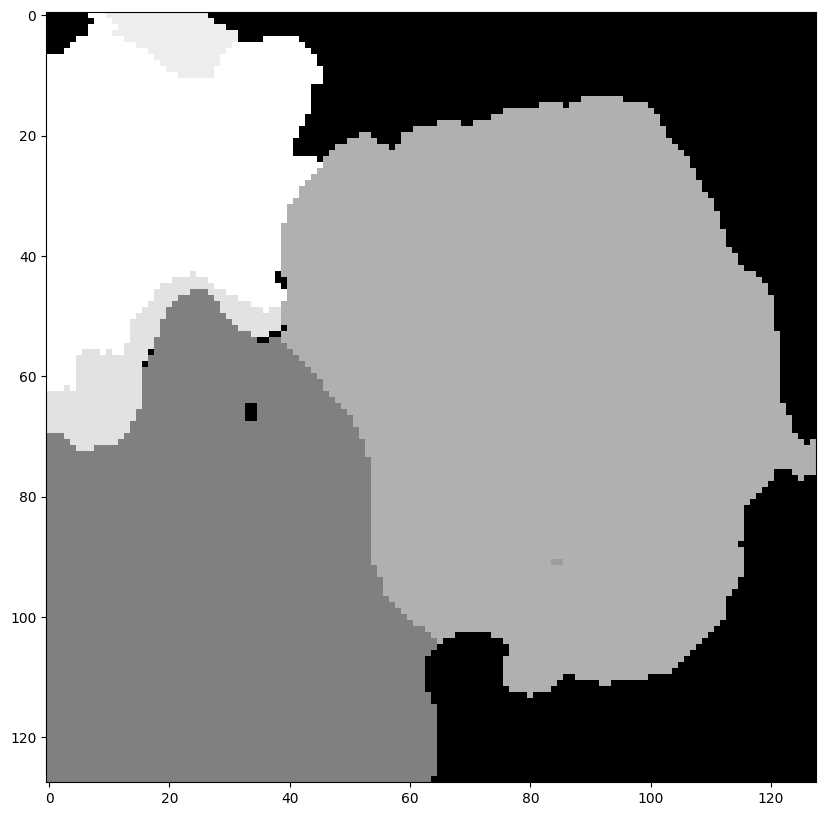

In [ ]:
import matplotlib.pyplot as plt

# Show the image
plt.figure(figsize=(10,10))
plt.imshow(segmentation_image, cmap='gray')
plt.show()
